## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

if 0 == len(objpoints):
    print('length 0 objpoints')
else:
    print('objpoints: ', objpoints)



length 0 objpoints


## And so on and so forth...

In [14]:
#interrupt

In [15]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def makeCalibrationList():
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('images: ', images)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(50)
        else:
            print('False ret')
         

    cv2.destroyAllWindows()
    return corners

#corners = []
if 0 == len(objpoints):
    print('length 0 objpoints')
    corners = makeCalibrationList()
else:
    print('objpoints length: ', len(objpoints) )

    

length 0 objpoints
images:  ['camera_cal/calibration14.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration12.jpg']
False ret
False ret
False ret


In [16]:
def undistortImg(image):
    # Do camera calibration given object points and image points
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    #cv2.imwrite('calibration_wide/test_undist.jpg',dst)
    return undistorted


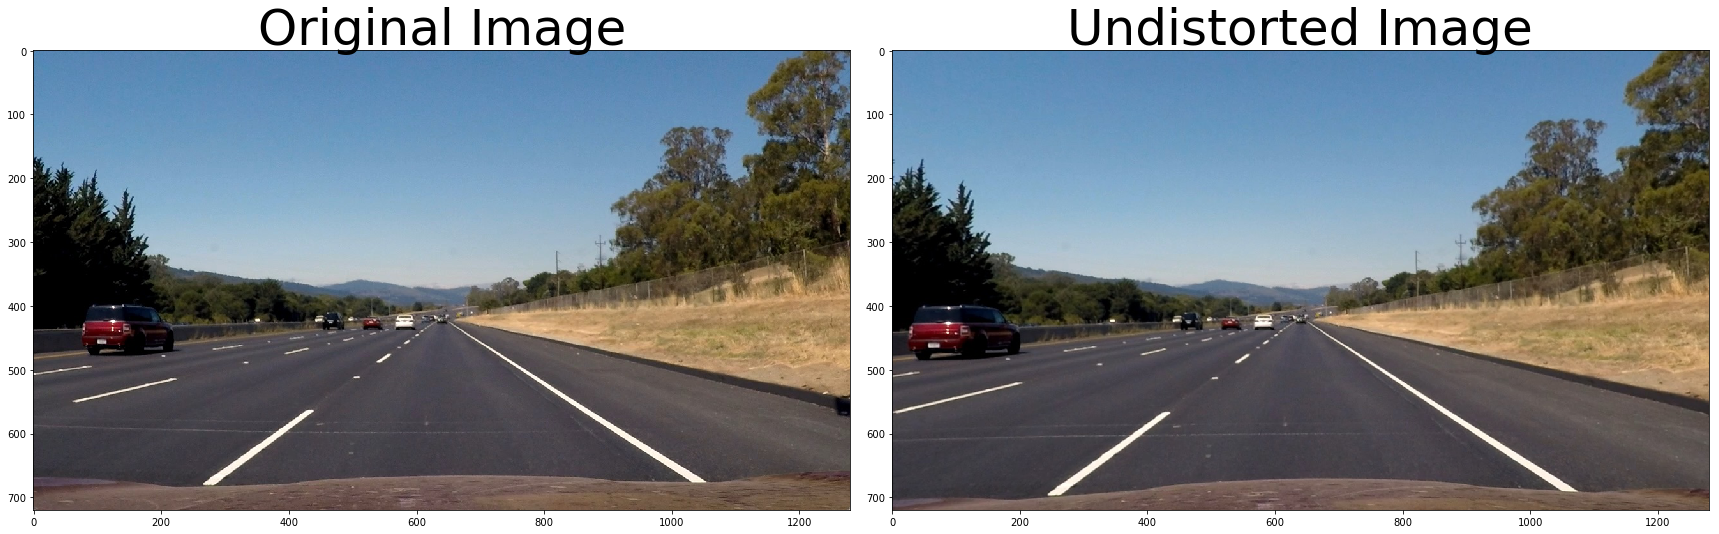

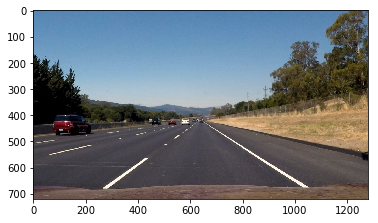

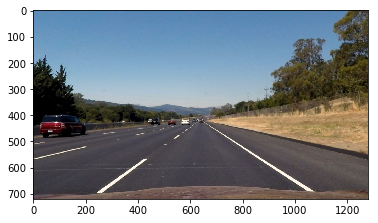

In [17]:
# test on a image
filename = 'test_images/straight_lines1.jpg'
#filename = 'test_images/test6.jpg'
#filename = 'test_images/test4.jpg'
filename = 'test_images/straight_lines2.jpg'
#filename = 'test_images/solidYellowLeft.jpg'

image = mpimg.imread(filename)
#edgedetect = edgedetect(image)
undistorted = undistortImg(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.show()

plt.imshow(image)
plt.show()

plt.imshow(undistorted)
plt.show()


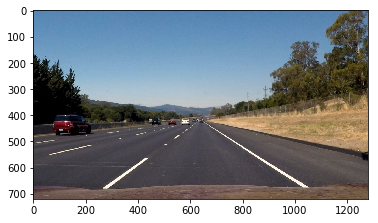

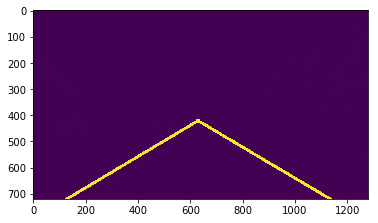

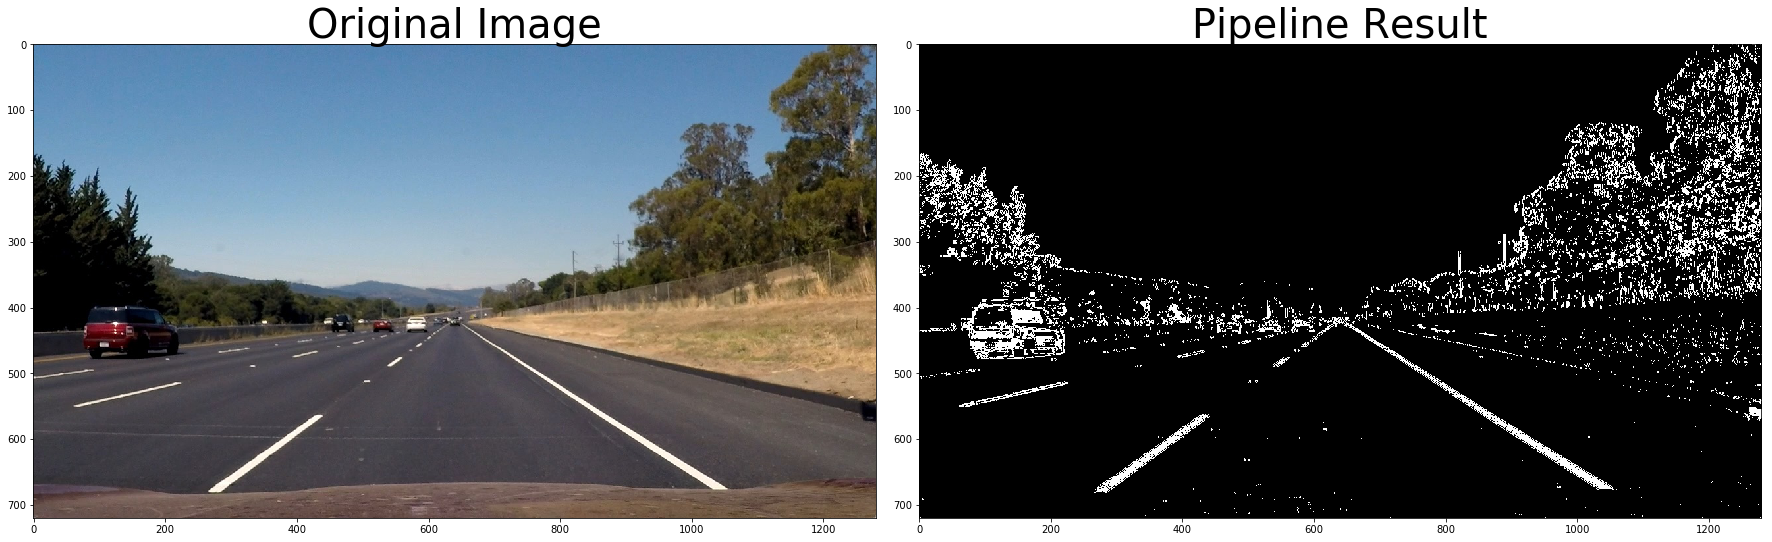

In [52]:
#image = mpimg.imread('bridge_shadow.jpg')
# from "30 Color and Gradient"
# Edit this function to create your own pipeline.
def colorandgradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

    
plt.imshow(image)
plt.show()

result = colorandgradient(image, (180, 255), (60, 100) )
result = colorandgradient(image )
hough = houghgreen(result)
plt.imshow(hough)
plt.show()


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(result)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [33]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if (0 == len(lines) ):
        print('None == lines')
        return None
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


# calculate the extrapolated line by trying to calculate an slope/intercept combination, and draw it.
def draw_lines_extrapolate(line_image, lines, vertice_y, color=[255, 0, 0], thickness=2):
    try:
        
        lines_left_lane = []
        lines_right_lane = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                intercept = y1 - slope * x1
                # separate slopt > 0 and slope < 0, one is right lane and another left lane. 
                # and try to remove outliers by only accepting values between 0.2 to 0.8 
                # https://discussions.udacity.com/t/extrapolating-lane-lines/272912/12
                if (0.2 < slope < 0.8):
                    lines_right_lane.append((slope, intercept) )
                elif (-0.8 < slope < -0.2):
                    lines_left_lane.append((slope, intercept) )
                else:
                    # maybe I should count outliers here
                    pass
    #    print('right :', lines_right_lane)
    #    print('left :', lines_left_lane)
        # find an average slope/intercept combination for left and right lane.
        
        imgshape = line_image.shape
    #    print(imgshape)

        if len(lines_right_lane) == 0:
            print(' len(lines_right_lane) == 0')
        else:
            lines_right_lane_array = np.array(lines_right_lane)
            average_right_slope = np.average(lines_right_lane_array[:, 0])
            average_right_intercept = np.average(lines_right_lane_array[:, 1])
            rightlane_y1 = imgshape[0]
            rightlane_y2 = vertice_y
            rightlane_x1 = (int)((rightlane_y1 - average_right_intercept)  / average_right_slope)
            rightlane_x2 = (int)((rightlane_y2 - average_right_intercept)  / average_right_slope)
            cv2.line(line_image, (rightlane_x1, rightlane_y1), (rightlane_x2, rightlane_y2), color, thickness)
        

        try:
            # to catch a exception happend during processing solidYellowLeft.mp4 at 93% .
            if len(lines_left_lane) == 0:
                print(' len(lines_left_lane) == 0 ')
            else:
                lines_left_lane_array = np.array(lines_left_lane)
                average_left_slope = np.average(lines_left_lane_array[:, 0])
                average_left_intercept = np.average(lines_left_lane_array[:, 1])
                
                leftlane_y1 = imgshape[0]
                leftlane_y2 = vertice_y
                leftlane_x1 = (int)((leftlane_y1 - average_left_intercept)  / average_left_slope)
                leftlane_x2 = (int)((leftlane_y2 - average_left_intercept)  / average_left_slope)
            #    print("extrapolated right lane:", rightlane_x1, rightlane_y1, rightlane_x2, rightlane_y2)
                cv2.line(line_image, (leftlane_x1, leftlane_y1), (leftlane_x2, leftlane_y2), color, thickness)
        except:
            print('lines_left_lane: ', lines_left_lane)
            return
    #    print('average_right_slope: ', average_right_slope)
    #    print('average_right_intercept: ', average_right_intercept)
    #    print('average_left_slope: ', average_left_slope)

    except Exception as e:
        print('exception: ' + str(e))
        return
       
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



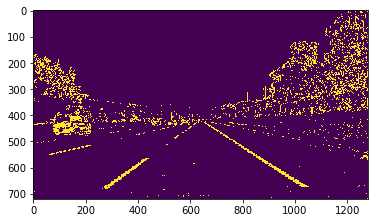

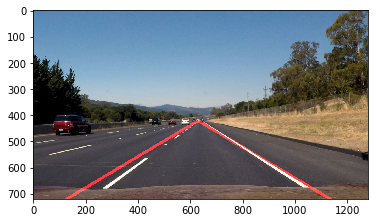

In [50]:
def getvertices(imshape):
    vertice_y = 420
#    imshape = image.shape
    vertice_y_up = 420
    vertice_y_down = imshape[0] - 60
#    print('imshape[0]: ', imshape[0])
#    print('vertice_y_down: ', vertice_y_down)
    vertice_x_left = 550
    vertice_x_right = 650
    vertices = np.array([[(0, vertice_y_down),
                          (vertice_x_left, vertice_y_up),
                          (vertice_x_right, vertice_y_up), 
                          (imshape[1], vertice_y_down) ] ], dtype=np.int32)
#     vertices = np.array([[(250, vertice_y_down),
#                           (vertice_x_left, vertice_y_up),
#                           (vertice_x_right, vertice_y_up), 
#                           (1100, vertice_y_down) ] ], dtype=np.int32)
    return vertices
    
def houghgreen(image):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    vertice_y = 420
#    vertice_y = 480

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid

    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments

    imshape = image.shape
    vertices = getvertices(imshape)
    masked_edges = region_of_interest(result, vertices)

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
#     print('lines : ', lines)
    
    # Iterate over the output "lines" and draw lines on a blank image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    draw_lines_extrapolate(line_image, lines, vertice_y, (255, 0, 0), 10)
    lines_edges = weighted_img(image, line_image)
    return lines_edges
    
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
    draw_lines(line_img, lines, [0, 255, 0])
    
    lines_edges = weighted_img(image, line_img)
    plt.imshow(lines_edges)
    return lines_edges
    
    plt.imshow(line_img)
    return line_img

hough = houghgreen(image)
plt.imshow(result)
plt.show()
plt.imshow(hough)
plt.show()

    

In [21]:

#interrupt


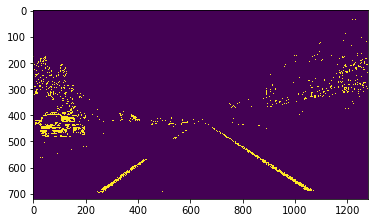

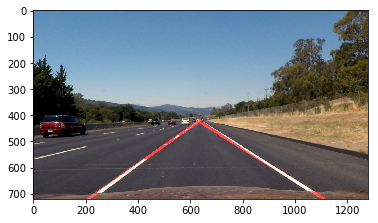

In [25]:
def process_one_image(image):
    image = undistortImg(image)

    result = colorandgradient(image, (180, 255), (60, 100) )
    plt.imshow(result)
    plt.show()
    
    hough = houghgreen(image)
    plt.imshow(hough)
    plt.show()
    
    return hough

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return process_one_image(image)


filename = 'test_images/straight_lines2.jpg'
image = mpimg.imread(filename)
processed = process_one_image(image)



In [23]:
interrupt

NameError: name 'interrupt' is not defined

In [ ]:
# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



In [ ]:

interrupt


In [ ]:
# from discussion forum.
# from discussion forum.
# from discussion forum.

filename = 'test_images/straight_lines2.jpg'
#filename = 'test_images/solidYellowLeft.jpg'
img = mpimg.imread(filename)


# https://discussions.udacity.com/t/perspective-transform/235255/7
# LetTheAIDrive
# i = 1
# images = glob.glob('./test_images/*.jpg')
# print('images[i] : ', images[i])
# img = cv2.imread(images[i])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

top_left = [630,420]
top_right = [650,420]
bottom_right = [1130,720]
bottom_left = [200,720]
pts = np.array([bottom_left,bottom_right,top_right,top_left])

top_left_dst = [200,0]
top_right_dst = [1130,0]
bottom_right_dst = [1130,720]
bottom_left_dst = [200,720]
dst_pts = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

## you can plot this and see that lines are properly chosen
## cv2.polylines(img,[pts],True,(255,0,0), 5)
## cv2.polylines(img,[dst_pts],True,(0,0,255), 5)

pts = np.float32(pts.tolist())
dst_pts = np.float32(dst_pts.tolist())

## M is the transformation matrix
M = cv2.getPerspectiveTransform(pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, pts)

# https://discussions.udacity.com/t/perspective-transform/235255/7
# driveWell 
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])
## M is the transformation matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 15)) 
image_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(img, M, dsize = image_size, flags = cv2.INTER_LINEAR)
ax1.imshow(img) 
ax2.imshow(warped)

## Helper Functions
Copied from P1 lane lines


In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
   
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


       
    

In [ ]:

interrupt

In [ ]:
def warp_image(image):
    # Todo
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 0 # offset for dst points
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])
    # Todo
    # For source points,
#    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#     imshape = image.shape
#     src = getvertices(imshape).astype(float)
#     src = np.float32([src[0, 1], src[0, 2], src[0, 3], src[0, 0] ])
    
    imshape = image.shape
    print('imshape: ', imshape)
    vertices = getvertices(imshape)
    print('vertices: ', vertices, type(vertices[0, 0]))
    cropped = region_of_interest(image, vertices)
    plt.imshow(cropped)
    plt.show()
    
    
    # Todo
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    src = np.float32([vertices[0, 1], vertices[0, 2], vertices[0, 3], vertices[0, 0] ])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
#    print('corners: ', corners)
    print('src: ', src, type(src[0, 0]))
    print('dst: ', dst, type(dst[0, 0]))
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
#    M = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
#    print('image: ', image)
    warped = cv2.warpPerspective(cropped, M, img_size)
#    print('warped: ', warped)
    plt.imshow(warped)
    plt.show()

    return warped


# imshape = image.shape
# print('imshape: ', imshape)
# src = getvertices(imshape)
# print('src: ', src, type(src[0, 0]))
# cropped = region_of_interest(image, src)
# plt.imshow(cropped)
# plt.show()


warped = warp_image(edgedetect)
# plt.imshow(edgedetect)
# plt.show()
# plt.imshow(warped)
# plt.show()


In [ ]:
interrupt here.